# HarvestStat Data Profiling - Yemen

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:2089' # Yemen
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/YE_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Yemen',
    'product':['R011','R012','R013','R014','R015','R016','R017','R018'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint,  params=parameters, proxies={}, auth=auth)
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1998	 | YE1998A1 | 19	| nan	| 0	| nan	| 0	|
| 2001	 | YE2001A1 | 19	| nan	| 0	| nan	| 0	|
| 2004	 | YE2004A1 | 21	| nan	| 0	| nan	| 0	|
| 2014	 | YE2014A1 | 22	| YE2014A2	| 333	| nan	| 0	|
----------------------------------------------- #


In [3]:
#%% Manual modification for several issues in FDW-YE
# ----------------------------------------------- #
# YE_admin1_1990.shp is not provided
# Difference between YE_admin1_1990.xls and YE_admin1_1998.shp
YE_Admin1_1990 = pd.read_excel('../data/shapefile/fewsnet/YE_Names_1990_VQrJQS0.xls')
print(YE_Admin1_1990.loc[~YE_Admin1_1990['ADMIN1'].isin(YE_Admin1_1998['ADMIN1']), ['FNID','ADMIN1']])
print(YE_Admin1_1998.loc[~YE_Admin1_1998['ADMIN1'].isin(YE_Admin1_1990['ADMIN1']), ['FNID','ADMIN1']])
fnid_replace = YE_Admin1_1990[['FNID','ADMIN1']].merge(YE_Admin1_1998[['FNID','ADMIN1']], on='ADMIN1',how='inner')
dict_replace = fnid_replace[['FNID_y', 'FNID_x']].set_index('FNID_y').to_dict()['FNID_x']
# Temporarily, we imitate a shapeifile using QGIS
YE_Admin1_1990 = gpd.read_file('../data/shapefile/fewsnet/temp/YE_Admin1_1990.shp').to_crs(epsg)
YE_Admin1_1990["area"] = YE_Admin1_1990["geometry"].area/10**6
YE_Admin1_1990['FNID'] = YE_Admin1_1990['FNID'].replace(dict_replace)
shape_all = pd.concat([shape_all, YE_Admin1_1990], axis=0)
# ----------------------------------------------- #
# Remove "Former North Yemen" (YE1990A142)
df = df[df['fnid'] != 'YE1990A142'].reset_index(drop=True)
# ----------------------------------------------- #
# Replace product name
df['product'] = df['product'].replace({
    'Maize, other (Unspecified)':'Maize (Corn)',
    'Maize/corn planting seed':'Maize (Corn)',
    'Wheat planting seed':'Wheat Grain',
    'Millet (Planting Seed)':'Millet',
    'Sorghum (planting seed)':'Sorghum'
})
# ----------------------------------------------- #
# Replace season name
df['season_name'] = df['season_name'].replace({
    'Annual Harvest': "Annual"
})

          FNID              ADMIN1
17  YE1990A142  Former North Yemen
         FNID    ADMIN1
1  YE1998A130  Al Dali'
8  YE1998A129     Amran


In [4]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# 2. Manual setting
# a) Add admin names to reporting units
admin_level = 'admin_1'
reporting_unit = df.loc[df['fnid'].map(lambda x: x[6] != 'A'), 'fnid'].unique()
df.loc[df.fnid.isin(reporting_unit),admin_level] = df.loc[df.fnid.isin(reporting_unit), 'locality_name'].map(lambda x: x.split(' ')[0])
# 3. Remove duplicate data 
pub_name_remove = 'BOS, Lesotho, Statisitical Report, 2017/2018 Crop Forecasting Report, NO 21 of 2040'
df = df[df['publication_name'] != pub_name_remove]
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([
    YE_Admin1_1990, YE_Admin1_1998, YE_Admin1_2004, YE_Admin1_2014
], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 27,499
Removed 5,842 "Missing Value" points
0/4,306 "Area Harvested" points are retained.
7,219/7,731 "Area Planted" points are retained.
7,219/7,731 "Quantity Produced" points are retained.
7,219/7,731 "Yield" points are retained.
Current data points: 21,657

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1990 - 2019
43 grain types are found: Almond (unspecified), Apple (unspecified), Apricot, Banana (unspecified), Barley (Unspecified), Bean (Green, unspecified), Beans (Red Kidney), Beans (mixed), Broad Beans, Cantaloupe, Carrots, Chilles and Peppers, Coffee (unspecified), Date (unspecified), Fenugreek, Fig (unspecified), Grape (unspecified), Green bean (fresh), Groundnuts (In Shell), Guava (unspecified), Lemon (unspecified), Lentils, Maize (Corn), Mandarin orange, Mango (unspecified), Millet, Okras (Fresh), Onions, Orange (unspecified), Papaya (un

- Yemen crop seasonal calendar

<img src="https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-yemen.png?itok=4Orq68Vz" width=900>

- FDW data consists of `YE1990A1`, `YE2004A1`, and `YE2014A1`.

| Year | Admin-1 | # units  | Admin-2  | # units |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1998	 | YE1998A1 | 19	| nan	| 0	| nan	| 
| 2001	 | YE2001A1 | 19	| nan	| 0	| nan	|
| 2004	 | YE2004A1 | 21	| nan	| 0	| nan	|
| 2014	 | **`YE2014A1`** | 22	| YE2014A2	| 333	| 

- Comparison between admin boundaries.

<img src="../figures/YE_admin_shapes.png"  width=900>

- In 1998, two districts are added: 

| 1990-1998|1998-2004|
| :---:|:---:|
|YE1990A140	(Sana'a) | YE1998A134 (Sana'a), YE1998A129 (Amran)|
|Unknown | Unknown, YE1998A130 (Al Dali')|

- in 2004, one district is divided, and two districts are added: 

| 1998-2004|2004-2014|
| :---:|:---:|
|YE1998A134	(Sana'a) | YE2004A123 (Sana'a), YE2004A113 (Sana'a City), YE2004A131 (Raymah)|

- **`YE2014A1`** is used to represent current admin-level 1 crop data.
- Yemen has 1 crop season: `Annual Harvest (12-01)`.
- Yemen has no crop production system.
- Yemen has no population group.

In [5]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = YE_Admin1_2014.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [6]:
# Link admin boundaries ------------------------- #
link_1990, over_1990 = FDW_PD_CreateAdminLink(YE_Admin1_1990, YE_Admin1_2014, 'ADMIN1', 'ADMIN1', prod, epsg)
link_1990['YE1990A133'].update(method='PBR')
link_2004, over_2004 = FDW_PD_CreateAdminLink(YE_Admin1_2004, YE_Admin1_2014, 'ADMIN1', 'ADMIN1', prod, epsg)
link_2004['YE2004A135'].update(method='PBR')
# Crop specific ratios
link_ratio_1990 = FDW_PD_RatioAdminLink(link_1990, prod, over_1990, mdx_pss)
link_ratio_2004 = FDW_PD_RatioAdminLink(link_2004, prod, over_2004, mdx_pss)
# Merge link_ratio
assert link_ratio_1990.keys() == link_ratio_2004.keys()
link_merged = [link_ratio_1990, link_ratio_2004]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Manual Editing
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=True)
# ----------------------------------------------- #

CBR is considered for 'YE1990A133' as no record found in: ['YE2014A132']
CBR is considered for 'YE2004A135' as no record found in: ['YE2014A132']


In [7]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = crop_new.T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

# Save data
fn_out = '../data/crop/adm_crop_production_YE.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')

All [country, season_name] are in the external season calendar.
../data/crop/adm_crop_production_YE.csv is saved.


## Visualization of production data

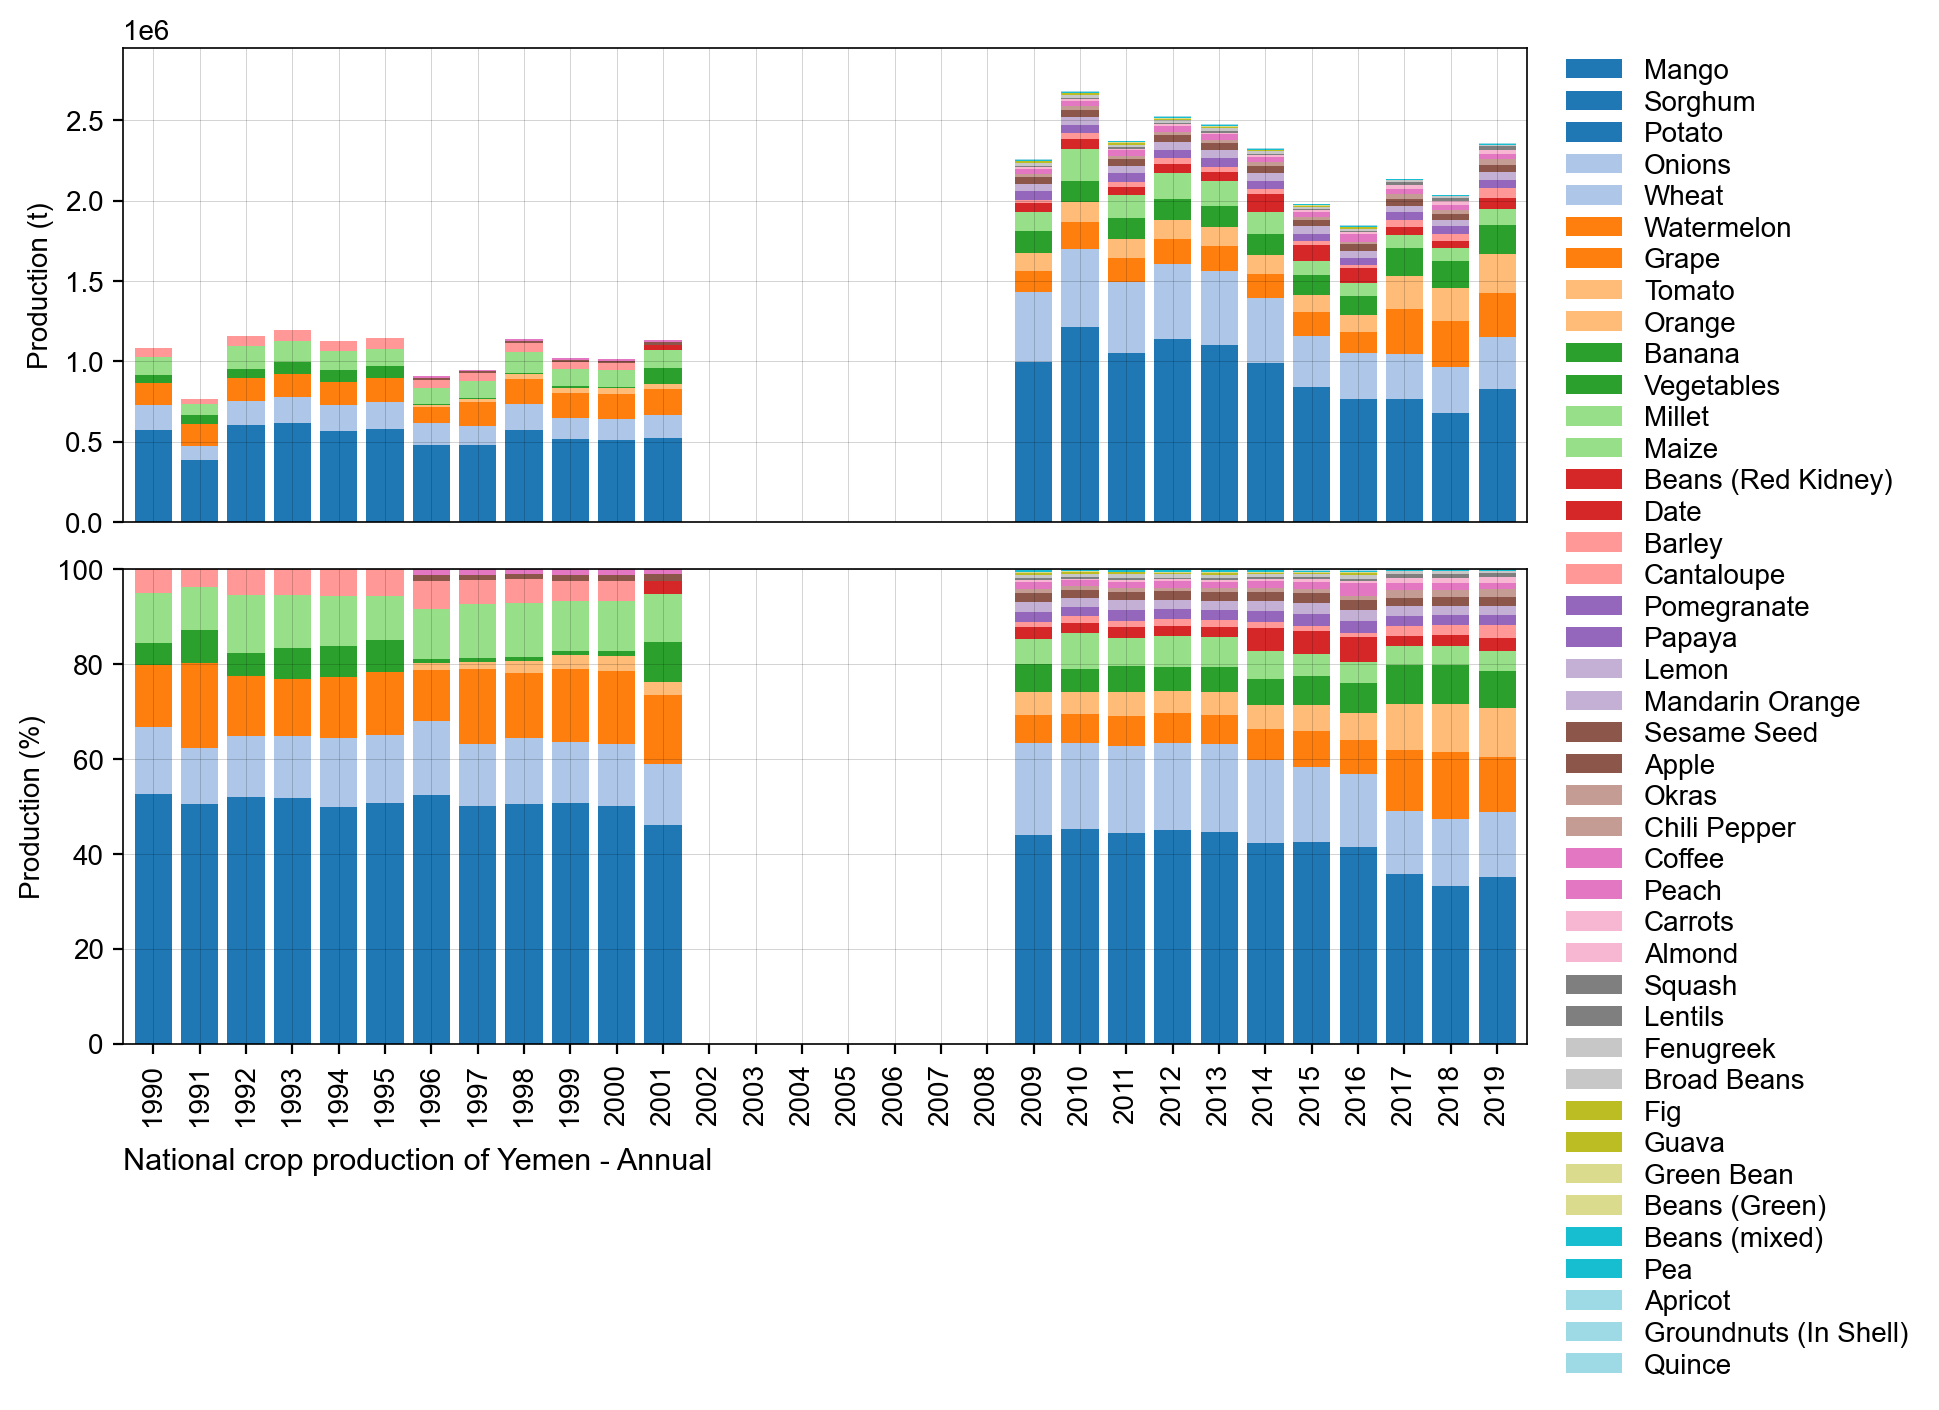

../figures/YE_bar_natgrainprod_Annual.png is saved.


In [8]:
# Bar chart of national crop production
country_iso, country_name = 'YE', 'Yemen'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Annual']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

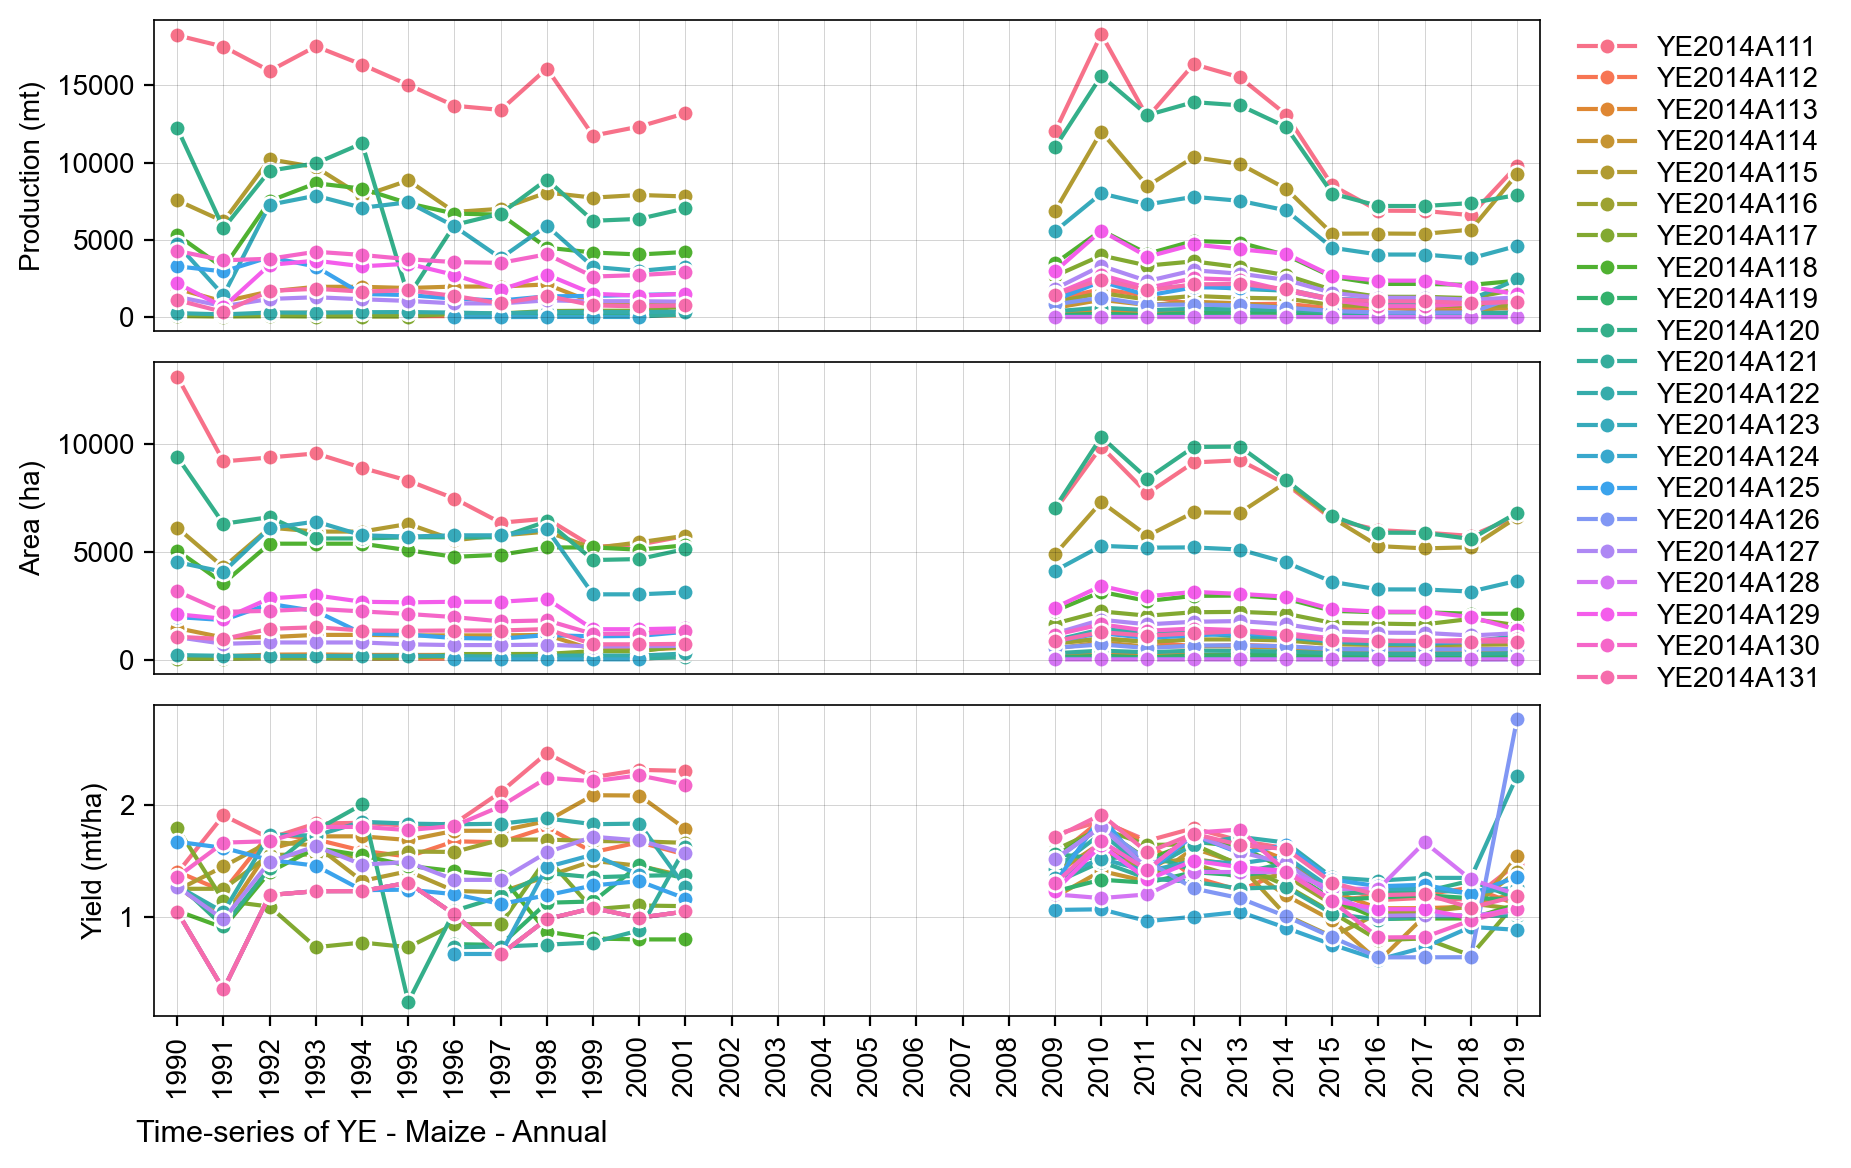

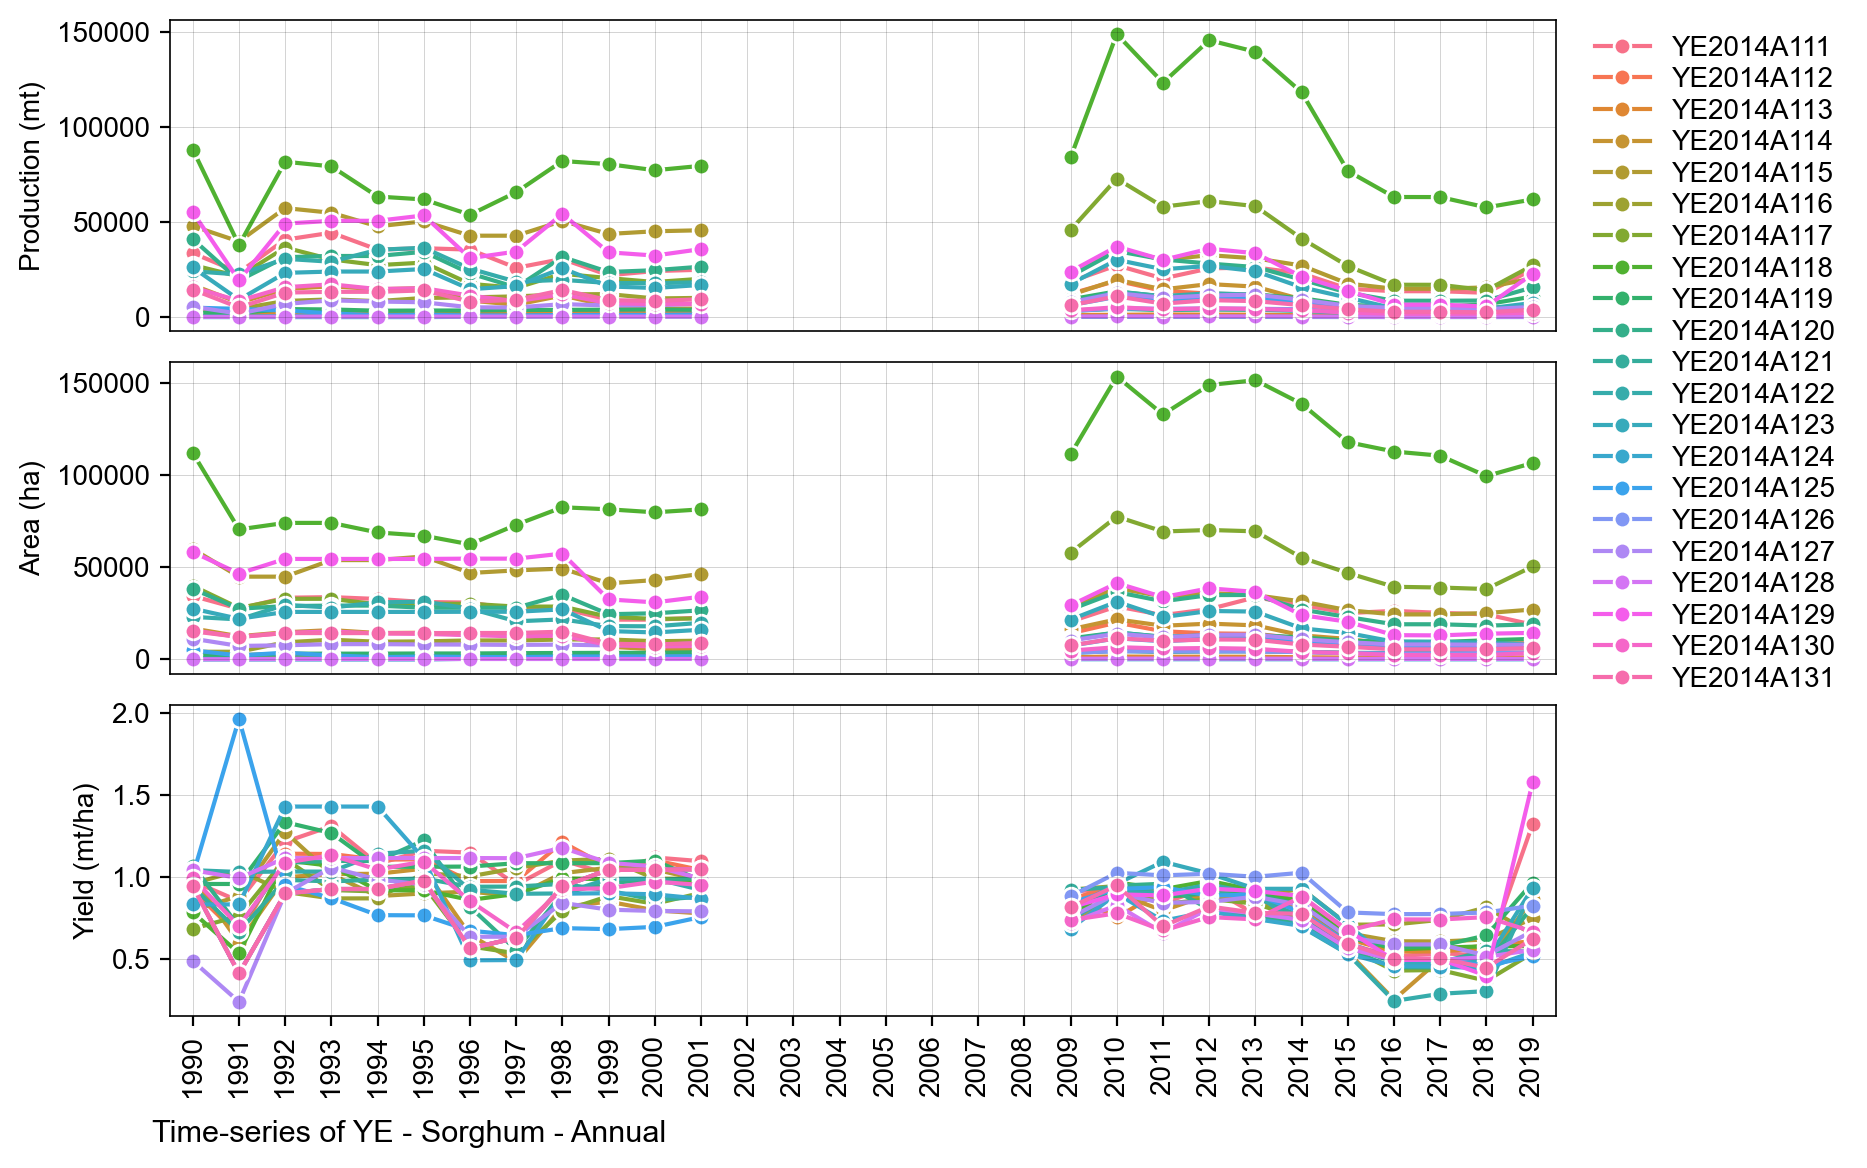

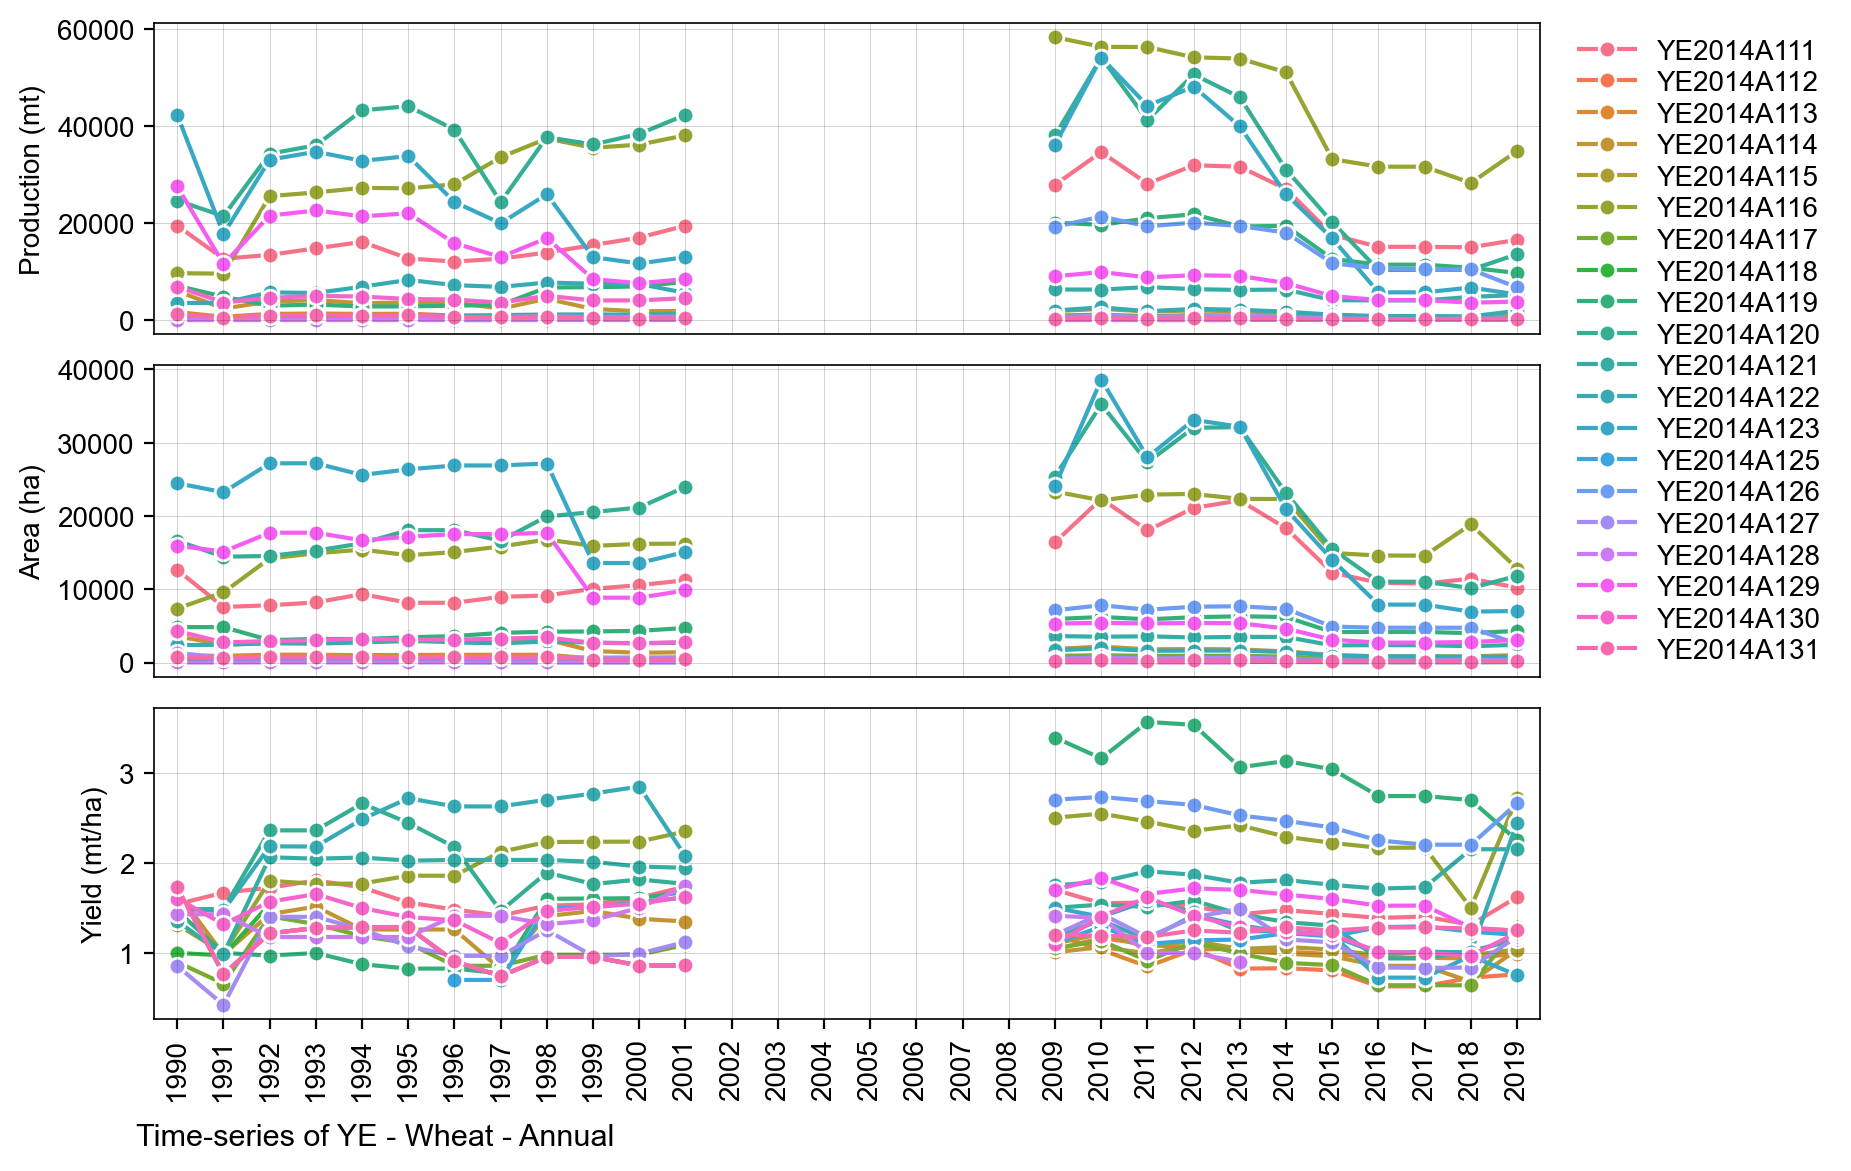

In [9]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'YE', 'Yemen'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Maize','Annual'],
    ['Sorghum','Annual'],
    ['Wheat','Annual'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)